In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 7551
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  4MPGEE3V_08_05_10
NN-MODEL FILENAME:  ./models/4MPGEE3V_08_05_10_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:4])
        old_min = np.array(boundary[4:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[4] = clamp(C_POS_ABS_MIN, newboundary[4], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[5] = clamp(C_VEL_ABS_MIN, newboundary[5], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[6] = clamp(P_ANG_ABS_MIN, newboundary[6], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[7] = clamp(P_VEL_ABS_MIN, newboundary[7], P_VEL_ABS_MAX)
    
#     newboundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
#                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1278.80 MiB, increment: 1058.60 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15739
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 67
TOTAL SERIAL TIMESTEPS:   15739
TOTAL PARALLEL TIMESTEPS: 67


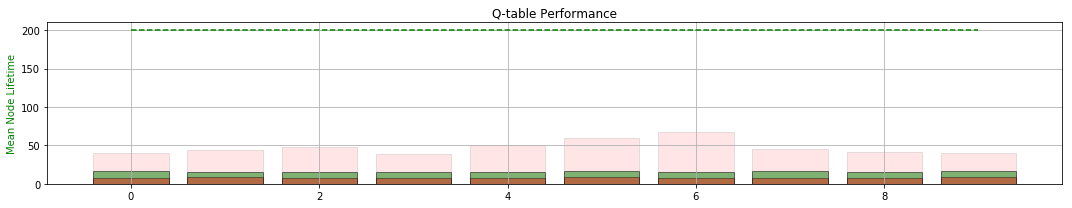

MEMORY COUNTER:  15739
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 548.322	LOSS : 507.571	LOSS : 492.247	LOSS : 489.383	LOSS : 460.647	LOSS : 458.821	LOSS : 441.433	LOSS : 425.385	LOSS : 428.318	LOSS : 437.223	LOSS : 424.755	LOSS : 443.791	LOSS : 410.728	LOSS : 389.161	LOSS : 384.962	LOSS : 401.136	LOSS : 376.660	LOSS : 385.635	LOSS : 367.909	LOSS : 380.951	
Validating... MEAN TIME:  115.045
LOSS : 361.435	LOSS : 362.966	LOSS : 352.076	LOSS : 367.790	LOSS : 354.632	LOSS : 364.617	LOSS : 349.678	LOSS : 367.929	LOSS : 371.447	LOSS : 366.877	LOSS : 355.619	LOSS : 359.772	LOSS : 360.617	LOSS : 355.663	LOSS : 374.723	LOSS : 375.707	LOSS : 360.560	LOSS : 362.508	LOSS : 368.325	LOSS : 368.339	
Validating... MEAN TIME:  136.25
LOSS : 367.250	LOSS : 366.286	LOSS : 377.025	LOSS : 388.893	LOSS : 365.240	LOSS : 369.991	LOSS : 392.569	LOSS : 383.765	LOSS : 389.588	LOSS : 382.288	LOSS : 377.940	LOSS : 379.949	LOSS : 391.031	LOSS : 396.933	LOSS : 417.376	LOSS : 411.644	LOSS : 39

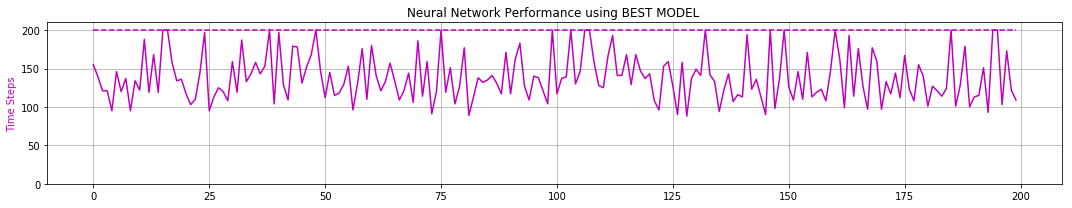

0 -max- [ 0.346  2.233  0.224  2.466]
0 -min- [-0.157 -1.233 -0.189 -2.708]

peak memory: 1362.43 MiB, increment: 1084.07 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.472  2.287  0.226  1.931]
1 -min- [-0.046 -0.810 -0.189 -2.547]

peak memory: 1390.19 MiB, increment: 1072.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.367  2.087  0.213  1.623]
2 -min- [-0.116 -0.685 -0.189 -2.714]

peak memory: 1371.21 MiB, increment: 1035.55 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.246  2.134  0.219  2.133]
3 -min- [-0.107 -0.988 -0.189 -2.502]

peak memory: 1390.48 MiB, increment: 1035.14 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.370  2.342  0.228  2.055]
4 -min- [-0.185 -1.017 -0.188 -2.611]

peak memory: 1425.45 MiB, increment: 1050.62 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.523  3.046  0.230  2.342]
5 -min- [-0.137 -1.139 -0.188 -2.793]

peak memory: 1446.18 MiB, increment: 1053.92 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.038  3.186  0.229  1.961]
6 -min- 

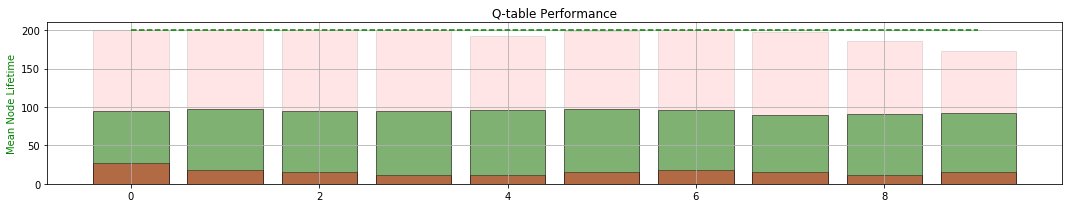

MEMORY COUNTER:  110069
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 376.040	LOSS : 301.959	LOSS : 281.230	LOSS : 272.688	LOSS : 264.402	LOSS : 224.751	LOSS : 232.798	LOSS : 209.553	LOSS : 220.865	LOSS : 206.141	LOSS : 213.091	LOSS : 227.585	LOSS : 222.606	LOSS : 225.281	LOSS : 209.470	LOSS : 221.904	LOSS : 214.827	LOSS : 220.053	LOSS : 222.791	LOSS : 223.919	
Validating... MEAN TIME:  95.91
LOSS : 211.489	LOSS : 204.622	LOSS : 223.196	LOSS : 218.754	LOSS : 232.273	LOSS : 214.915	LOSS : 217.913	LOSS : 219.714	LOSS : 224.271	LOSS : 225.782	LOSS : 223.202	LOSS : 216.101	LOSS : 217.303	LOSS : 205.138	LOSS : 206.609	LOSS : 215.296	LOSS : 228.207	LOSS : 215.840	LOSS : 218.377	LOSS : 224.758	
Validating... MEAN TIME:  107.355
LOSS : 219.714	LOSS : 224.431	LOSS : 221.058	LOSS : 223.690	LOSS : 246.591	LOSS : 229.917	LOSS : 217.633	LOSS : 231.511	LOSS : 228.927	LOSS : 235.955	LOSS : 231.992	LOSS : 246.163	LOSS : 221.682	LOSS : 250.326	LOSS : 228.974	LOSS : 246.373	LOSS : 25

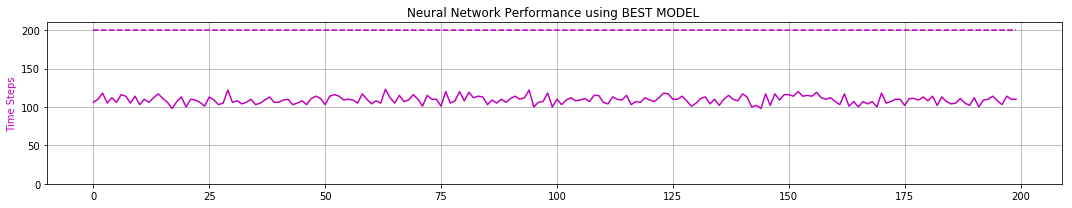

0 -max- [ 0.999  1.849  0.229  1.971]
0 -min- [-1.321 -1.882 -0.188 -2.101]

peak memory: 1589.03 MiB, increment: 1079.57 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.746  1.700  0.229  1.922]
1 -min- [-1.027 -1.859 -0.188 -1.924]

peak memory: 1560.23 MiB, increment: 1016.07 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.899  1.629  0.230  2.451]
2 -min- [-1.103 -1.851 -0.188 -1.787]

peak memory: 1572.04 MiB, increment: 1016.18 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.904  1.730  0.230  2.145]
3 -min- [-1.195 -2.239 -0.188 -1.826]

peak memory: 1627.05 MiB, increment: 1054.64 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.904  2.086  0.230  2.308]
4 -min- [-1.099 -2.032 -0.188 -1.740]

peak memory: 1663.66 MiB, increment: 1071.43 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.899  1.760  0.230  2.445]
5 -min- [-1.220 -2.061 -0.189 -2.091]

peak memory: 1661.39 MiB, increment: 1054.25 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.888  2.294  0.230  2.510]
6 -min- 

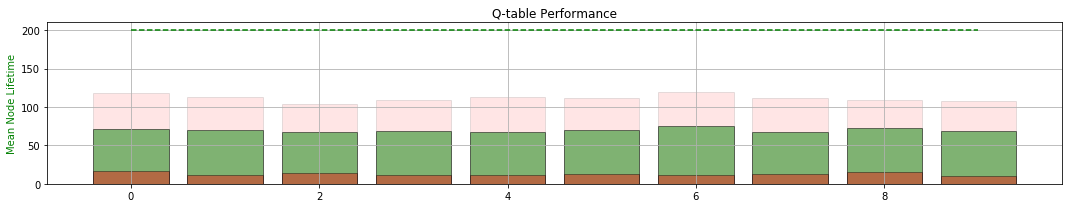

MEMORY COUNTER:  179992
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 291.405	LOSS : 298.385	LOSS : 306.753	LOSS : 297.072	LOSS : 279.238	LOSS : 294.725	LOSS : 271.722	LOSS : 283.093	LOSS : 289.588	LOSS : 252.265	LOSS : 267.732	LOSS : 263.005	LOSS : 243.990	LOSS : 251.975	LOSS : 249.971	LOSS : 252.850	LOSS : 255.747	LOSS : 252.015	LOSS : 261.720	LOSS : 261.248	
Validating... MEAN TIME:  109.36
LOSS : 269.009	LOSS : 257.753	LOSS : 235.976	LOSS : 258.897	LOSS : 270.850	LOSS : 249.039	LOSS : 260.859	LOSS : 260.748	LOSS : 278.985	LOSS : 272.495	LOSS : 257.866	LOSS : 269.410	LOSS : 256.546	LOSS : 271.958	LOSS : 247.968	LOSS : 268.140	LOSS : 261.890	LOSS : 231.995	LOSS : 253.171	LOSS : 255.566	
Validating... MEAN TIME:  114.38
LOSS : 237.074	LOSS : 262.776	LOSS : 273.425	LOSS : 267.432	LOSS : 273.533	LOSS : 279.461	LOSS : 281.069	LOSS : 251.457	LOSS : 262.693	LOSS : 269.863	LOSS : 261.446	LOSS : 279.301	LOSS : 269.761	LOSS : 276.105	LOSS : 268.965	LOSS : 255.571	LOSS : 27

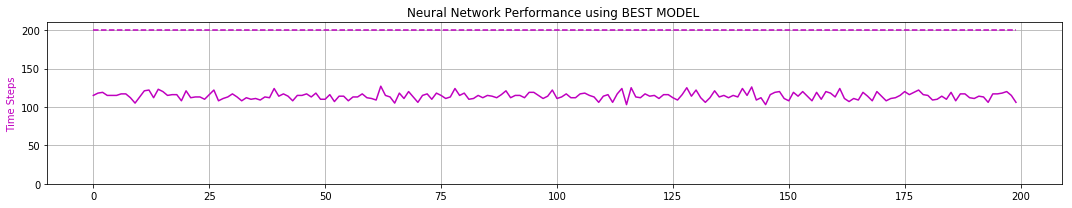

0 -max- [ 0.292  1.260  0.064  1.577]
0 -min- [-2.270 -3.471 -0.196 -1.342]

peak memory: 1642.41 MiB, increment: 976.93 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.309  1.447  0.080  1.582]
1 -min- [-2.267 -3.488 -0.195 -1.437]

peak memory: 1636.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.299  1.456  0.071  1.765]
2 -min- [-2.269 -3.589 -0.196 -1.527]

peak memory: 1636.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.309  1.438  0.069  1.715]
3 -min- [-2.270 -3.617 -0.196 -1.508]

peak memory: 1636.75 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.315  1.447  0.063  1.764]
4 -min- [-2.266 -3.486 -0.196 -1.590]

peak memory: 1675.08 MiB, increment: 1014.90 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.340  1.397  0.066  1.778]
5 -min- [-2.269 -3.599 -0.196 -1.557]

peak memory: 1694.52 MiB, increment: 995.79 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.342  1.366  0.073  1.563]
6 -min- [-2.2

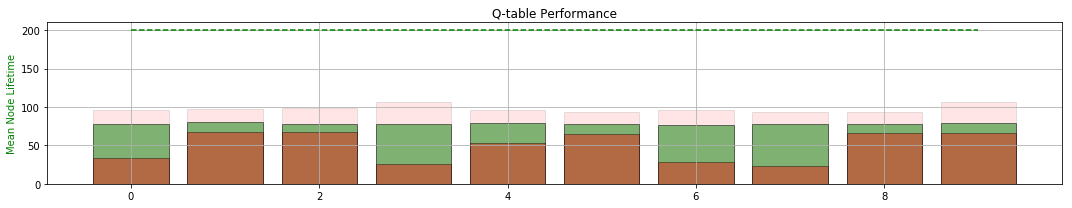

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 215.155	LOSS : 198.088	LOSS : 190.677	LOSS : 196.607	LOSS : 181.919	LOSS : 180.591	LOSS : 178.705	LOSS : 186.051	LOSS : 186.882	LOSS : 188.053	LOSS : 183.418	LOSS : 185.381	LOSS : 183.402	LOSS : 176.385	LOSS : 192.883	LOSS : 185.426	LOSS : 184.784	LOSS : 192.188	LOSS : 166.943	LOSS : 175.300	
Validating... MEAN TIME:  120.325
LOSS : 167.015	LOSS : 179.202	LOSS : 180.414	LOSS : 170.370	LOSS : 146.618	LOSS : 155.980	LOSS : 161.587	LOSS : 154.820	LOSS : 171.043	LOSS : 154.916	LOSS : 149.861	LOSS : 146.154	LOSS : 158.307	LOSS : 154.555	LOSS : 141.830	LOSS : 156.152	LOSS : 152.284	LOSS : 165.017	LOSS : 151.170	LOSS : 160.928	
Validating... MEAN TIME:  122.265
LOSS : 159.627	LOSS : 146.560	LOSS : 139.914	LOSS : 147.305	LOSS : 152.952	LOSS : 156.339	LOSS : 147.285	LOSS : 147.221	LOSS : 155.123	LOSS : 142.614	LOSS : 156.146	LOSS : 149.926	LOSS : 152.293	LOSS : 150.179	LOSS : 135.955	LOSS : 138.084	LOSS : 

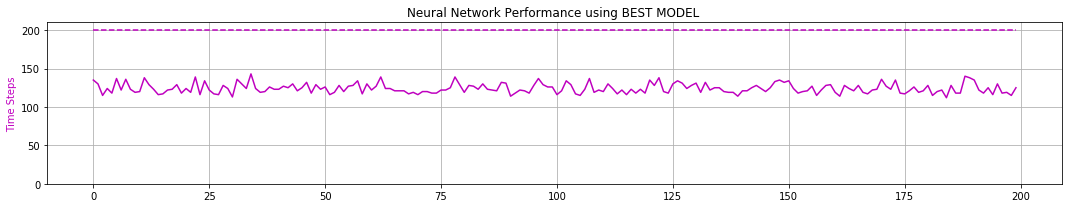

0 -max- [ 0.256  1.000  0.063  0.897]
0 -min- [-1.632 -2.416 -0.196 -1.148]

peak memory: 1730.09 MiB, increment: 976.71 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.265  1.025  0.063  0.813]
1 -min- [-2.221 -2.927 -0.196 -1.114]

peak memory: 1730.09 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.277  1.140  0.063  0.853]
2 -min- [-1.914 -2.594 -0.196 -1.336]

peak memory: 1730.09 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.288  1.022  0.063  0.789]
3 -min- [-2.262 -2.879 -0.196 -1.099]

peak memory: 1730.09 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.292  1.004  0.063  1.007]
4 -min- [-1.914 -2.604 -0.196 -1.089]

peak memory: 1730.09 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.269  1.117  0.064  0.791]
5 -min- [-1.623 -2.415 -0.196 -1.248]

peak memory: 1730.09 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.308  1.180  0.062  1.034]
6 -min- [-2.24

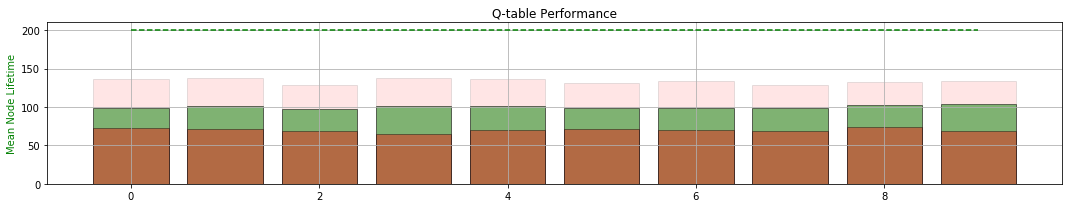

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 115.945	LOSS : 124.177	LOSS : 128.740	LOSS : 115.975	LOSS : 114.933	LOSS : 139.587	LOSS : 140.192	LOSS : 128.394	LOSS : 135.989	LOSS : 133.781	LOSS : 127.299	LOSS : 150.757	LOSS : 130.521	LOSS : 139.208	LOSS : 134.158	LOSS : 147.524	LOSS : 137.225	LOSS : 141.163	LOSS : 120.576	LOSS : 135.854	
Validating... MEAN TIME:  105.58
LOSS : 135.709	LOSS : 128.146	LOSS : 127.622	LOSS : 129.299	LOSS : 133.543	LOSS : 136.041	LOSS : 147.125	LOSS : 143.110	LOSS : 125.623	LOSS : 126.370	LOSS : 127.390	LOSS : 127.776	LOSS : 126.162	LOSS : 129.047	LOSS : 121.075	LOSS : 114.057	LOSS : 123.980	LOSS : 135.201	LOSS : 133.308	LOSS : 130.496	
Validating... MEAN TIME:  104.875
LOSS : 125.511	LOSS : 139.064	LOSS : 132.436	LOSS : 138.520	LOSS : 122.890	LOSS : 122.172	LOSS : 127.766	LOSS : 127.988	LOSS : 136.340	LOSS : 140.646	LOSS : 134.682	LOSS : 128.666	LOSS : 122.665	LOSS : 126.054	LOSS : 139.770	LOSS : 148.890	LOSS : 1

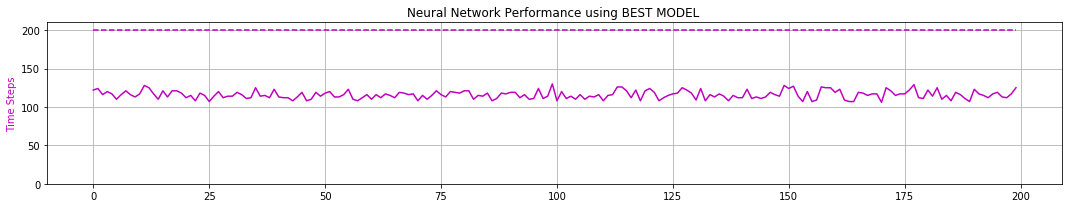

0 -max- [ 1.808  3.710  0.190  4.264]
0 -min- [-2.600 -4.638 -0.250 -4.472]

peak memory: 1636.58 MiB, increment: 976.78 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.815  3.708  0.190  4.373]
1 -min- [-2.600 -4.641 -0.250 -4.474]

peak memory: 1753.65 MiB, increment: 976.89 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.815  3.710  0.190  4.286]
2 -min- [-2.600 -4.639 -0.250 -4.487]

peak memory: 1753.65 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.819  3.709  0.190  4.312]
3 -min- [-2.600 -4.639 -0.250 -4.474]

peak memory: 1753.65 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.816  3.758  0.191  4.300]
4 -min- [-2.600 -4.643 -0.250 -4.542]

peak memory: 1753.65 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.824  3.789  0.190  4.292]
5 -min- [-2.600 -4.645 -0.250 -4.565]

peak memory: 1773.18 MiB, increment: 976.81 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.818  3.770  0.190  4.419]
6 -min- [-2.60

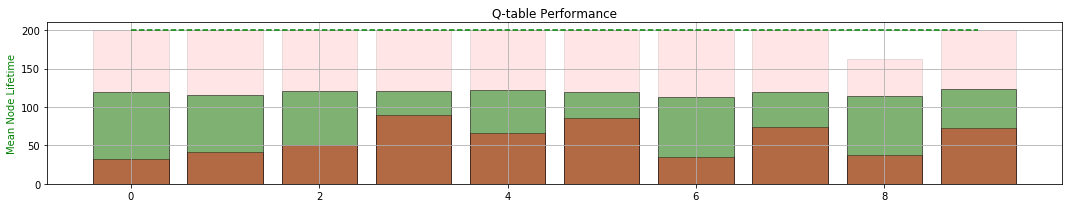

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 133.950	LOSS : 125.419	LOSS : 127.834	LOSS : 110.876	LOSS : 109.530	LOSS : 96.886	LOSS : 112.468	LOSS : 109.133	LOSS : 96.427	LOSS : 111.923	LOSS : 114.647	LOSS : 111.311	LOSS : 102.712	LOSS : 121.167	LOSS : 124.951	LOSS : 131.177	LOSS : 111.750	LOSS : 129.961	LOSS : 124.510	LOSS : 120.849	
Validating... MEAN TIME:  114.2
LOSS : 112.539	LOSS : 108.948	LOSS : 109.136	LOSS : 108.337	LOSS : 123.161	LOSS : 108.850	LOSS : 98.781	LOSS : 106.755	LOSS : 105.259	LOSS : 121.359	LOSS : 110.293	LOSS : 102.626	LOSS : 118.522	LOSS : 117.982	LOSS : 121.074	LOSS : 126.491	LOSS : 111.353	LOSS : 119.699	LOSS : 125.428	LOSS : 118.893	
Validating... MEAN TIME:  113.83
LOSS : 119.867	LOSS : 102.195	LOSS : 112.067	LOSS : 105.132	LOSS : 117.640	LOSS : 112.661	LOSS : 111.352	LOSS : 92.215	LOSS : 101.678	LOSS : 92.303	LOSS : 105.905	LOSS : 102.968	LOSS : 127.573	LOSS : 128.865	LOSS : 123.244	LOSS : 110.599	LOSS : 129.739	

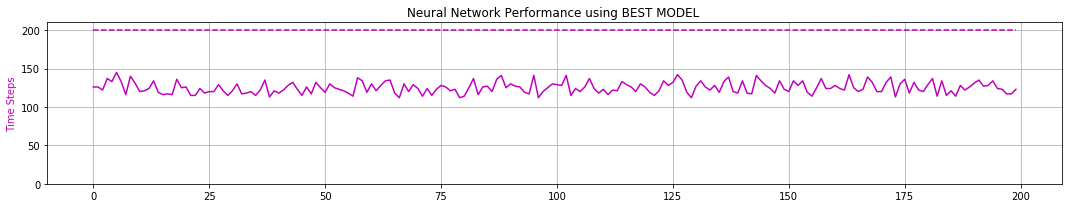

0 -max- [ 1.568  3.336  0.230  3.894]
0 -min- [-2.600 -4.398 -0.250 -3.733]

peak memory: 1796.29 MiB, increment: 976.66 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.405  3.119  0.228  3.923]
1 -min- [-2.600 -4.389 -0.250 -3.722]

peak memory: 1874.50 MiB, increment: 976.47 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.569  3.275  0.231  4.052]
2 -min- [-2.600 -4.393 -0.250 -3.788]

peak memory: 1871.11 MiB, increment: 973.09 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.485  3.201  0.230  3.997]
3 -min- [-2.600 -4.388 -0.250 -3.745]

peak memory: 1874.05 MiB, increment: 976.03 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.550  3.342  0.231  3.938]
4 -min- [-2.600 -4.394 -0.250 -3.791]

peak memory: 1874.59 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.412  3.171  0.231  3.831]
5 -min- [-2.600 -4.387 -0.250 -3.802]

peak memory: 1796.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.326  3.045  0.226  3.837]
6 -min- [-2.60

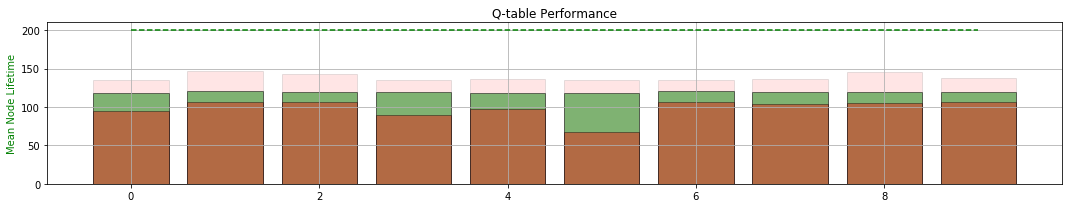

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 86.406	LOSS : 99.710	LOSS : 86.584	LOSS : 100.850	LOSS : 89.261	LOSS : 87.349	LOSS : 80.417	LOSS : 86.380	LOSS : 90.136	LOSS : 87.524	LOSS : 88.080	LOSS : 105.675	LOSS : 106.677	LOSS : 110.660	LOSS : 81.500	LOSS : 82.935	LOSS : 74.564	LOSS : 80.210	LOSS : 84.507	LOSS : 81.528	
Validating... MEAN TIME:  116.1
LOSS : 87.520	LOSS : 90.994	LOSS : 95.234	LOSS : 93.122	LOSS : 89.963	LOSS : 80.920	LOSS : 83.888	LOSS : 81.531	LOSS : 84.749	LOSS : 84.227	LOSS : 86.400	LOSS : 91.185	LOSS : 90.650	LOSS : 92.335	LOSS : 87.030	LOSS : 93.937	LOSS : 99.514	LOSS : 74.495	LOSS : 85.620	LOSS : 91.242	
Validating... MEAN TIME:  124.61
LOSS : 96.300	LOSS : 78.143	LOSS : 88.037	LOSS : 84.810	LOSS : 86.271	LOSS : 84.829	LOSS : 90.039	LOSS : 79.072	LOSS : 85.444	LOSS : 84.559	LOSS : 88.692	LOSS : 89.792	LOSS : 95.564	LOSS : 85.267	LOSS : 96.497	LOSS : 77.357	LOSS : 89.577	LOSS : 107.031	LOSS : 79.435	LOSS : 85.660	
Vali

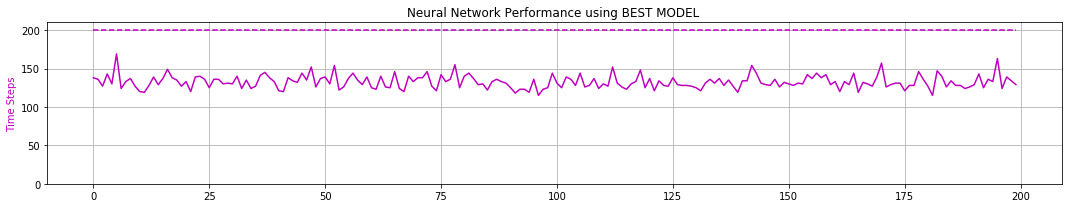

0 -max- [ 1.162  2.613  0.177  3.106]
0 -min- [-2.600 -4.214 -0.250 -2.988]

peak memory: 1818.62 MiB, increment: 976.90 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.068  2.498  0.176  2.884]
1 -min- [-2.600 -4.180 -0.250 -2.974]

peak memory: 1896.00 MiB, increment: 975.81 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.166  2.605  0.178  3.013]
2 -min- [-2.600 -4.197 -0.250 -3.012]

peak memory: 1818.62 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.113  2.556  0.178  2.956]
3 -min- [-2.600 -4.172 -0.250 -2.982]

peak memory: 1818.62 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.155  2.644  0.177  2.929]
4 -min- [-2.600 -4.176 -0.250 -3.019]

peak memory: 1818.62 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.066  2.532  0.178  2.864]
5 -min- [-2.600 -4.128 -0.250 -3.016]

peak memory: 1818.62 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.013  2.453  0.175  2.862]
6 -min- [-2.60

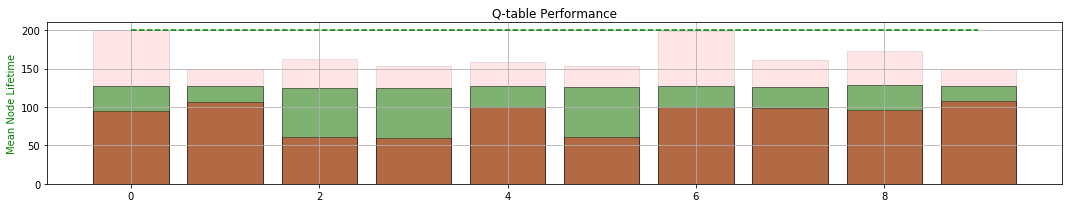

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 90.063	LOSS : 106.356	LOSS : 118.219	LOSS : 109.138	LOSS : 116.181	LOSS : 116.847	LOSS : 112.462	LOSS : 114.643	LOSS : 105.906	LOSS : 95.372	LOSS : 115.119	LOSS : 125.081	LOSS : 103.430	LOSS : 104.358	LOSS : 104.750	LOSS : 106.004	LOSS : 103.226	LOSS : 106.318	LOSS : 101.580	LOSS : 111.186	
Validating... MEAN TIME:  114.77
LOSS : 111.038	LOSS : 118.622	LOSS : 131.461	LOSS : 140.948	LOSS : 134.566	LOSS : 114.657	LOSS : 102.127	LOSS : 115.502	LOSS : 103.935	LOSS : 118.339	LOSS : 116.571	LOSS : 124.753	LOSS : 104.283	LOSS : 127.206	LOSS : 140.834	LOSS : 115.927	LOSS : 121.261	LOSS : 139.083	LOSS : 113.093	LOSS : 107.778	
Validating... MEAN TIME:  119.965
LOSS : 114.662	LOSS : 120.341	LOSS : 114.254	LOSS : 117.300	LOSS : 122.124	LOSS : 116.517	LOSS : 102.747	LOSS : 121.559	LOSS : 108.036	LOSS : 102.839	LOSS : 108.121	LOSS : 117.765	LOSS : 129.481	LOSS : 125.366	LOSS : 111.971	LOSS : 119.061	LOSS : 123

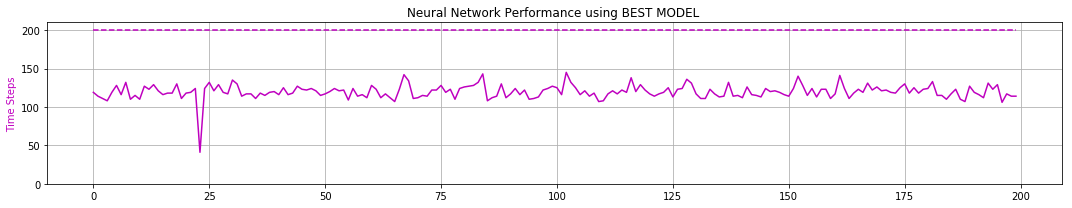

0 -max- [ 0.923  2.263  0.144  2.565]
0 -min- [-2.600 -4.080 -0.250 -2.609]

peak memory: 1858.02 MiB, increment: 976.96 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.851  2.152  0.144  2.477]
1 -min- [-2.600 -4.041 -0.250 -2.568]

peak memory: 1858.02 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.922  2.247  0.145  2.560]
2 -min- [-2.600 -4.113 -0.250 -2.622]

peak memory: 1779.89 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.875  2.225  0.143  2.554]
3 -min- [-2.600 -4.056 -0.250 -2.724]

peak memory: 1779.89 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.901  2.261  0.144  2.557]
4 -min- [-2.600 -4.056 -0.250 -2.631]

peak memory: 1874.45 MiB, increment: 976.88 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.851  2.212  0.148  2.494]
5 -min- [-2.600 -4.085 -0.250 -2.628]

peak memory: 1796.32 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.821  2.160  0.149  2.461]
6 -min- [-2.60

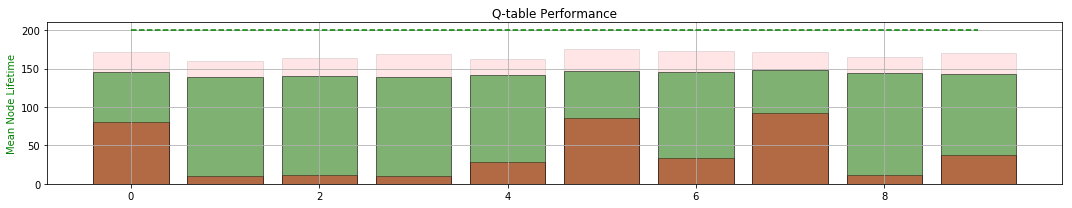

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 515.449	LOSS : 219.055	LOSS : 182.375	LOSS : 171.599	LOSS : 175.037	LOSS : 149.421	LOSS : 142.280	LOSS : 120.628	LOSS : 122.237	LOSS : 101.861	LOSS : 104.523	LOSS : 102.665	LOSS : 109.607	LOSS : 109.820	LOSS : 101.028	LOSS : 91.155	LOSS : 98.721	LOSS : 93.752	LOSS : 89.940	LOSS : 90.808	
Validating... MEAN TIME:  182.8
LOSS : 81.472	LOSS : 88.985	LOSS : 89.752	LOSS : 94.285	LOSS : 97.719	LOSS : 101.375	LOSS : 91.746	LOSS : 87.640	LOSS : 85.655	LOSS : 81.321	LOSS : 82.085	LOSS : 77.929	LOSS : 85.187	LOSS : 83.785	LOSS : 73.301	LOSS : 79.833	LOSS : 89.537	LOSS : 87.096	LOSS : 74.237	LOSS : 84.027	
Validating... MEAN TIME:  186.76
LOSS : 82.390	LOSS : 86.171	LOSS : 88.914	LOSS : 74.626	LOSS : 80.630	LOSS : 80.292	LOSS : 86.768	LOSS : 93.619	LOSS : 84.478	LOSS : 80.444	LOSS : 107.479	LOSS : 82.182	LOSS : 87.488	LOSS : 84.408	LOSS : 76.968	LOSS : 78.544	LOSS : 81.446	LOSS : 81.763	LOSS : 73.409	LOSS : 

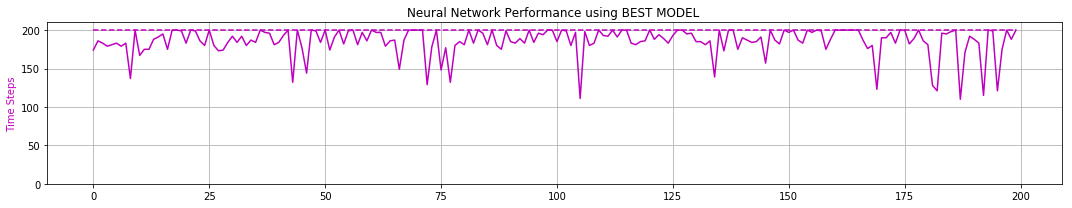

0 -max- [ 2.600  2.636  0.229  2.526]
0 -min- [-1.841 -3.201 -0.210 -2.490]

peak memory: 1799.15 MiB, increment: 976.77 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  3.109  0.228  2.561]
1 -min- [-1.847 -3.252 -0.200 -2.496]

peak memory: 1877.28 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  2.712  0.226  2.557]
2 -min- [-1.825 -3.225 -0.198 -2.450]

peak memory: 1799.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  2.737  0.230  2.594]
3 -min- [-1.839 -3.257 -0.219 -2.580]

peak memory: 1799.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  2.902  0.229  2.579]
4 -min- [-1.836 -3.195 -0.192 -2.522]

peak memory: 1818.56 MiB, increment: 976.95 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  2.894  0.227  2.438]
5 -min- [-1.832 -3.214 -0.202 -2.499]

peak memory: 1916.22 MiB, increment: 976.80 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  2.740  0.229  2.470]
6 -min- [-1.83

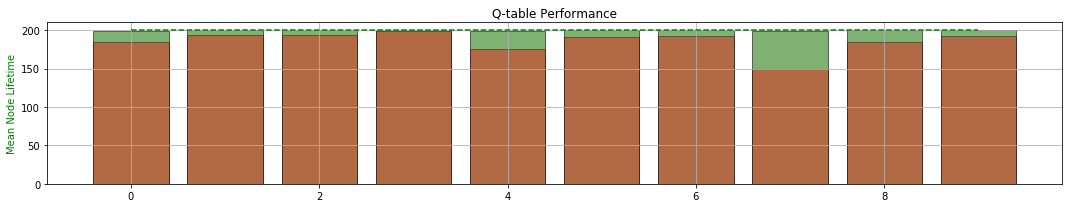

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1555.0
Total Serial Timesteps   :  1065698.0
Speed-up                 :  685.34


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  7551 SUCCESS 149   9    1555    1065698     685.34
